# Class Exercise - MCTS with TSP
- Tal Zilkha - tiz2102
- Mat Hillman - mh3691

# MCTS

In [1]:
import math
import numpy as np
EPS = 1e-8

class MCTS():
    """
    This class handles the MCTS tree.
    """

    def __init__(self, game, nnet, args):
        self.game = game
        self.nnet = nnet
        self.args = args
        self.Qsa = {}       # stores Q values for s,a (as defined in the paper)
        self.Nsa = {}       # stores #times edge s,a was visited
        self.Ns = {}        # stores #times board s was visited
        self.Ps = {}        # stores initial policy (returned by neural net)

        self.Es = {}        # stores game.getGameEnded ended for board s
        self.Vs = {}        # stores game.getValidMoves for board s
        
        self.val = [float('inf')]
        self.num_sim = [0]

    def getActionProb(self, state, temp=1):
        """
        This function performs numMCTSSims simulations of MCTS starting from
        canonicalBoard.
        Returns:
            probs: a policy vector where the probability of the ith action is
                   proportional to Nsa[(s,a)]**(1./temp)
        """
        for i in range(self.args.numMCTSSims):
            self.search(state, i)

        s = self.game.stringRepresentation(state)
        counts = [self.Nsa[(s,a)] if (s,a) in self.Nsa else 0 for a in range(self.game.getActionSize())]
        
        if temp==0:
            bestA = np.argmax(counts)
            probs = [0]*len(counts)
            probs[bestA]=1
            return probs

        counts = [x**(1./temp) for x in counts]
        counts_sum = float(sum(counts))
        probs = [x/counts_sum for x in counts]
        return probs


    def search(self, state, num_sim):
        """
        This function performs one iteration of MCTS. It is recursively called
        till a leaf node is found. The action chosen at each node is one that
        has the maximum upper confidence bound as in the paper.
        Once a leaf node is found, the neural network is called to return an
        initial policy P and a value v for the state. This value is propagated
        up the search path. In case the leaf node is a terminal state, the
        outcome is propagated up the search path. The values of Ns, Nsa, Qsa are
        updated.
        NOTE: the return values are the negative of the value of the current
        state. This is done since v is in [-1,1] and if v is the value of a
        state for the current player, then its value is -v for the other player.
        Returns:
            v: the negative of the value of the current canonicalBoard
        """

        s = self.game.stringRepresentation(state)
        
        if s not in self.Es:
            self.Es[s] = self.game.getGameEnded(state)
        if self.Es[s]!=0:
            # terminal node
            return 0

        if s not in self.Ps:
            # leaf node
            if self.nnet is not None:
                self.Ps[s], v = self.nnet.predict(state, self.game.graph)
            else:
                self.Ps[s] = np.ones(self.game.getActionSize()) # random policy
                v = 0
            valids = self.game.getValidMoves(state)
            self.Ps[s] = self.Ps[s]*valids      # masking invalid moves
            sum_Ps_s = np.sum(self.Ps[s])
            if sum_Ps_s > 0:
                self.Ps[s] /= sum_Ps_s    # renormalize
            else:
                # if all valid moves were masked make all valid moves equally probable
                
                # NB! All valid moves may be masked if either your NNet architecture is insufficient or you've get overfitting or something else.
                # If you have got dozens or hundreds of these messages you should pay attention to your NNet and/or training process.   
                print("All valid moves were masked, do workaround.")
                self.Ps[s] = self.Ps[s] + valids
                self.Ps[s] /= np.sum(self.Ps[s])

            self.Vs[s] = valids
            self.Ns[s] = 0
            return v

        valids = self.Vs[s]
        cur_best = -float('inf')
        best_act = -1

        # pick the action with the highest upper confidence bound
        for a in range(self.game.getActionSize()):
            if valids[a]:
                if (s,a) in self.Qsa:
                    u = self.Qsa[(s,a)] + self.args.cpuct*self.Ps[s][a]*math.sqrt(self.Ns[s])/(1+self.Nsa[(s,a)])
                else:
                    u = self.args.cpuct*self.Ps[s][a]*math.sqrt(self.Ns[s] + EPS)     # Q = 0 ?

                if u > cur_best:
                    cur_best = u
                    best_act = a

        a = best_act
        next_s, reward = self.game.getNextState(state, a)

        v = self.search(next_s, num_sim) + reward

        if (s,a) in self.Qsa:
            self.Qsa[(s,a)] = (self.Nsa[(s,a)]*self.Qsa[(s,a)] + v)/(self.Nsa[(s,a)]+1)
            self.Nsa[(s,a)] += 1

        else:
            self.Qsa[(s,a)] = v
            self.Nsa[(s,a)] = 1
            
        if self.game.getActionSize() - self.val[-1] < v:
            self.val += [self.game.getActionSize() - v]
            self.num_sim += [num_sim]

        self.Ns[s] += 1
        return v

# TSPGame

In [2]:
from itertools import permutations 

class TSPGame():
    """
    This class specifies the base Game class. To define your own game, subclass
    this class and implement the functions below. This works when the game is
    two-player, adversarial and turn-based.
    Use 1 for player1 and -1 for player2.
    See othello/OthelloGame.py for an example implementation.
    """
    def __init__(self, args):
        self.num_node = args.num_node
        self.graph = np.random.rand(self.num_node, 2)

    def getStartState(self):
        """
        Returns:
            start_state: a representation of the graph
        """
        start_state = np.zeros([self.num_node, 2])
        start_state[0,0] = 1
        start_state[0,1] = 1
        return start_state

    def getActionSize(self):
        """
        Returns:
            self.num_node: number of all possible actions
        """
        return self.num_node

    def getNextState(self, state, action):
        """
        Input:
            state: current state
            action: action taken by current player
        Returns:
            next_state: graph after applying action
            reward: reward from action
        """
        next_state = state.copy()
        next_state[:, 1] = 0
        next_state[action, :] = 1
        prev_action = np.where(state[:, 1] == 1)[0][0]
        prev_node = self.graph[prev_action]
        cur_node = self.graph[action]
        reward = 1 - np.linalg.norm(cur_node - prev_node)
        if self.num_node == np.sum(next_state[:, 0]):
            reward += 1 - np.linalg.norm(cur_node - self.graph[0])
            
        return next_state, reward

    def getValidMoves(self, state):
        """
        Input:
            state: current state
        Returns:
            1 - state[:, 0]: a binary vector of length self.getActionSize(), 1 for
                            moves that are valid from the current board and player,
                            0 for invalid moves
        """
        return 1 - state[:, 0]

    def getGameEnded(self, state):
        """
        Input:
            state: current state
        Returns:
            r: 0 if game has not ended. 1 if it has
               
        """
        r = 0
        if self.num_node == np.sum(state[:, 0]):
            r = 1
        return r

    def stringRepresentation(self, state):
        """
        Input:
            state: current state
        Returns:
            s: string representation of state
        """
        s = ''
        for i in range(self.num_node):
            s += str(int(state[i, 0]))
        return s
    
    def optimal_sol(self):
        """
        Input:
            
        Returns:
            optimal_val: optimal solution for TSP
            optimal_path: optimal path for TSP
        """
        cur_reward = 0
        optimal_val = float('inf')
        optimal_path = []
        graph = self.graph

        nodes = np.arange(self.num_node)[1:]
        perms = permutations(nodes)
        
        for perm in list(perms):
            cur_reward = 0
            
            cur_reward += np.linalg.norm(graph[0] - graph[perm[0]])
            for i in range(len(perm) - 1):
                j = perm[i]
                k = perm[i+1]
                cur_reward += np.linalg.norm(graph[k] - graph[j])
            cur_reward += np.linalg.norm(graph[perm[-1]] - graph[0])
            
            if optimal_val > cur_reward:
                optimal_val = cur_reward
                optimal_path = perm
        
        return optimal_val, optimal_path

# Configuration

In [47]:
class dotdict(dict):
    def __getattr__(self, name):
        return self[name]

args = dotdict({
    # MCTS args
    'numMCTSSims': 5000,          # Number of games moves for MCTS to simulate.
    'num_node': 8,                 # Number of nodes in the graph (game)
    
    # Train args
    'numIters': 1,              # Number of episods to play (5 times 10 episodes)
    'numEps': 1,              # Number of complete self-play games to simulate during a new iteration.
    'tempThreshold': 15,        #
    'updateThreshold': 0.6,     # During arena playoff, new neural net will be accepted if threshold or more of games are won.
    'maxlenOfQueue': 200000,    # Number of game examples to train the neural networks.
    'arenaCompare': 40,         # Number of games to play during arena play to determine if new net will be accepted.
    'cpuct': 1,
    'numItersForTrainExamplesHistory': 25,
    
    # NN args
    'lr': 0.001,
    'dropout': 0.3,
    'epochs': 100,
    'batch_size': 64,
    'cuda': False,
    'num_channels': 512,
    })

# Self Play

In [48]:
def play_game(args):
    game = TSPGame(args)
    mcts = MCTS(game, None, args)
    state = game.getStartState()
    mcts_reward = 0
    mcts_actions = []
    optimal_val, optimal_path = game.optimal_sol()
    
    while not game.getGameEnded(state):
        action = np.argmax(mcts.getActionProb(state))
        state, reward = game.getNextState(state, action)
        mcts_actions += [action]
        mcts_reward += reward
        
#     print('Optimal Solution:', optimal_val)
#     print('Optimal Action:', optimal_path)
#     print('MCTS Reward:', game.getActionSize() - mcts_reward)
#     print('MCTS Action:', mcts_actions)
    
    return mcts.val, mcts.num_sim, optimal_val

# Plot

In [7]:
val, num_sim, optimal_reward = play_game(args)
print(num_sim, val)

[0, 1, 2, 2, 3, 4, 5, 5, 6, 7, 7, 8, 8, 9, 222, 226, 435, 522, 743, 1760, 3658, 9482, 9502, 10869, 12878, 14271, 17564, 17940, 18079] [inf, 9.414540200949762, 9.313411159732421, 8.727951360682184, 8.344859632727674, 7.8163158832715744, 7.6744141835700725, 7.088954384519835, 6.559644402218701, 6.472677306028439, 5.887217506978201, 5.627224636139435, 5.041764837089198, 4.628857996335701, 4.57370901726899, 4.570752252459552, 4.182286853044377, 4.124901236426097, 3.872914190611355, 3.60966124824811, 3.6090937782776598, 3.33021732069221, 3.0757943787357416, 3.006403148784175, 2.9026898904538943, 2.7476673451533458, 2.7425828328293074, 2.6388695744990276, 2.483847029198479]


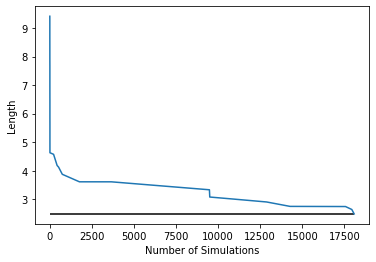

In [8]:
import matplotlib.pyplot as plt

plt.plot(np.array(num_sim[1:]), val[1:])
plt.hlines(optimal_reward, 0, num_sim[-1])
plt.xlabel("Number of Simulations")
plt.ylabel("Length")

# Part 1 (of Exercise)

In [ ]:
# code to run MCTS on 100 games
results = {}
optimal_vals = []
for i in range(100):
    if i % 10 == 0:
        print(i)
    val, num_s, optimal_reward = play_game(args)
    results[i] = {tuple(num_s): val}
    optimal_vals += [optimal_reward]

0
10
20
30


In [ ]:
# process results
import pandas as pd
columns = list(range(100))
df = pd.DataFrame(columns=columns)
i = 0
for result in results:
    sims = list(results[result].keys())[0]
    vals = list(results[result].values())[0]
    col = np.zeros(20000)
    j = 0
    for sim in sims:
    col[sim] = vals[j]
    j += 1
    df[i] = col
    i += 1

In [ ]:
for col in df:
    df[col] = df[col].replace(0.0, pd.np.nan)
    df[col] = df[col].ffill()

In [ ]:
df.drop(df.head(1).index, inplace=True)

In [ ]:
opt_val_row = pd.DataFrame([pd.Series(optimal_vals)], index=["opt"], dtype=float)
df = pd.concat([opt_val_row, df])
df.to_csv("100-games.csv")

In [ ]:
opt_vals = df[0:1]
opt_vals = opt_vals.iloc[0]
df.drop(df.head(1).index, inplace=True)

In [ ]:
df = df.reset_index(drop=True)

In [ ]:
# check how many simulations fall within 1.1 factor of optimal solution
within_factor = []
for i in range(19999):
    row = list(df.iloc[i])
    counter = 0
    for j in range(len(row)):
    if row[j] / opt_vals[j] <= 1.1:
        counter += 1
    within_factor += [counter / 100]

In [ ]:
# plot graph
import matplotlib.pyplot as plt

plt.plot(np.array(range(19999)), within_factor)
plt.title("Percentage of random instances which MCTS solved within a 1.1 factor of the optimal solution as a function of simulations")
plt.xlabel("Number of Simulations")
plt.ylabel("Percentage")
plt.ylim(top=within_factor[-1] + 0.05)

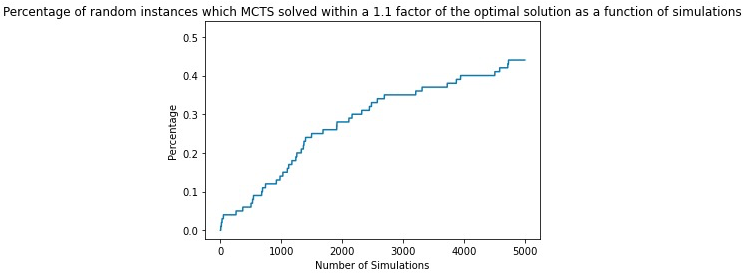

# Part 2 (of Exercise)

In [5]:
from collections import deque
import time, os, sys
from pickle import Pickler, Unpickler
from random import shuffle


class Coach():
    """
    This class executes the self-play + learning. It uses the functions defined
    in Game and NeuralNet. args are specified in main.py.
    """
    def __init__(self, game, nnet, args):
        self.game = game
        self.nnet = nnet
#         self.pnet = self.nnet.__class__(self.game)  # the competitor network
        self.args = args
        self.mcts = MCTS(self.game, self.nnet, self.args)
        self.trainExamplesHistory = []    # history of examples from args.numItersForTrainExamplesHistory latest iterations
        self.skipFirstSelfPlay = False    # can be overriden in loadTrainExamples()

    def executeEpisode(self):
        """
        This function executes one episode of self-play, starting with player 1.
        As the game is played, each turn is added as a training example to
        trainExamples. The game is played till the game ends. After the game
        ends, the outcome of the game is used to assign values to each example
        in trainExamples.

        It uses a temp=1 if episodeStep < tempThreshold, and thereafter
        uses temp=0.

        Returns:
            trainExamples: a list of examples of the form (canonicalBoard,pi,v)
                           pi is the MCTS informed policy vector, v is +1 if
                           the player eventually won the game, else -1.
        """
        trainExamples = []
        board = self.game.getStartState()
#         self.curPlayer = 1
        episodeStep = 0

        while True:
            episodeStep += 1
            temp = int(episodeStep < self.args.tempThreshold)

            pi = self.mcts.getActionProb(board, temp=temp)

            action = np.random.choice(len(pi), p=pi)
            next_board, reward = self.game.getNextState(board, action)
            trainExamples.append([board, self.game.graph, pi, reward])

            r = self.game.getGameEnded(next_board)
            
            if r!=0:
                return [tuple(x) for x in trainExamples]
            
            board = next_board

    def learn(self):
        """
        Performs numIters iterations with numEps episodes of self-play in each
        iteration. After every iteration, it retrains neural network with
        examples in trainExamples (which has a maximum length of maxlenofQueue).
        It then pits the new neural network against the old one and accepts it
        only if it wins >= updateThreshold fraction of games.
        """
        for i in range(1, self.args.numIters+1):
            # bookkeeping
#             print('------ITER ' + str(i) + '------')
            # examples of the iteration
            if not self.skipFirstSelfPlay or i>1:
                iterationTrainExamples = deque([], maxlen=self.args.maxlenOfQueue)

                for eps in range(self.args.numEps):
                    self.mcts = MCTS(self.game, self.nnet, self.args)   # reset search tree
                    iterationTrainExamples += self.executeEpisode()

                self.trainExamplesHistory.append(iterationTrainExamples)
                
            if len(self.trainExamplesHistory) > self.args.numItersForTrainExamplesHistory:
                print("len(trainExamplesHistory) =", len(self.trainExamplesHistory), " => remove the oldest trainExamples")
                self.trainExamplesHistory.pop(0)

            # shuffle examples before training
            trainExamples = []
            for e in self.trainExamplesHistory:
                trainExamples.extend(e)
            shuffle(trainExamples)
            
            # train
            # self.nnet.train(trainExamples)
        return trainExamples


In [7]:
import sys
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [8]:
class NNet():
    def __init__(self, game, args):
        self.b = game.num_node
        self.action_size = game.getActionSize()
        
        self.create_net(game)

    def train(self, examples):
        """
        examples: list of examples, each example is of form (board, pi, v)
        """
        print("Training...")
        input_boards, input_graphs, target_pis, target_vs = list(zip(*examples))
        input_boards = np.asarray(input_boards)
        input_graphs = np.asarray(input_graphs)
        target_pis = np.asarray(target_pis)
        target_vs = np.asarray(target_vs)
        self.model.fit(x = [input_boards, input_graphs], y = [target_pis, target_vs], batch_size = args.batch_size, epochs = args.epochs)

    def predict(self, board, graph):
        """
        board: np array with board
        """
        # preparing input
        board = board[np.newaxis, :, :]
        graph = graph[np.newaxis, :, :]

        # run
        pi, v = self.model.predict([board, graph])

        #print('PREDICTION TIME TAKEN : {0:03f}'.format(time.time()-start))
        return pi[0], v[0]
    
    def create_net(self, game):
        # Neural Net
        self.input_boards = Input(shape=game.getStartState().shape)    # s: batch_size x board_x x board_y

        x_image = Reshape((args['num_node'], 2, 1))(self.input_boards)                # batch_size  x board_x x board_y x 1
        h_conv1 = Activation('relu')(BatchNormalization(axis=3)(Conv2D(args.num_channels, 2, padding='same')(x_image)))         # batch_size  x board_x x board_y x num_channels
        h_conv2 = Activation('relu')(BatchNormalization(axis=3)(Conv2D(args.num_channels, 2, padding='same')(h_conv1)))         # batch_size  x board_x x board_y x num_channels
        h_conv3 = Activation('relu')(BatchNormalization(axis=3)(Conv2D(args.num_channels, 2, padding='same')(h_conv2)))        # batch_size  x (board_x) x (board_y) x num_channels
        h_conv4 = Activation('relu')(BatchNormalization(axis=3)(Conv2D(args.num_channels, 2, padding='valid')(h_conv3)))        # batch_size  x (board_x-2) x (board_y-2) x num_channels
        h_conv4_flat = Flatten()(h_conv4)       
        s_fc1 = Dropout(args.dropout)(Activation('relu')(BatchNormalization(axis=1)(Dense(1024)(h_conv4_flat))))  # batch_size x 1024
        s_fc2 = Dropout(args.dropout)(Activation('relu')(BatchNormalization(axis=1)(Dense(512)(s_fc1))))          # batch_size x 1024
        self.pi = Dense(self.action_size, activation='softmax', name='pi')(s_fc2)   # batch_size x self.action_size
        self.v = Dense(1, activation='tanh', name='v')(s_fc2)                    # batch_size x 1

        self.model = Model(inputs=self.input_boards, outputs=[self.pi, self.v])
        self.model.compile(loss=['categorical_crossentropy','mean_squared_error'], optimizer=Adam(args.lr))

# Part 3 (of Exercise)

Please note: Part 3 was ran on 8 nodes since we were approaching the deadline and wanted to submit some results. Otherwise, it would take a long time to build the training dataset and test games with more node.

In [16]:
def play_game_with_nn(args, nn):
    game = TSPGame(args)
    mcts = MCTS(game, nn, args)
    state = game.getStartState()
    mcts_reward = 0
    mcts_actions = []
    optimal_val, optimal_path = game.optimal_sol()
    
    while not game.getGameEnded(state):
        action = np.argmax(mcts.getActionProb(state))
        state, reward = game.getNextState(state, action)
        mcts_actions += [action]
        mcts_reward += reward
        
#     print('Optimal Solution:', optimal_val)
#     print('Optimal Action:', optimal_path)
#     print('MCTS Reward:', game.getActionSize() - mcts_reward)
#     print('MCTS Action:', mcts_actions)
    
    return mcts.val, mcts.num_sim, optimal_val

In [ ]:
# build training dataset
t = TSPGame(args)
n = NNet(t, args)
data_set = []
for i in range(100000):
    print("Game:", i)
    c = Coach(t, n, args)
    data_set.append(c.learn())
    t = TSPGame(args)

In [14]:
# shuffle data and train network
trainExamples = []
for d in data_set:
    for e in d:
        trainExamples.append(e)
shuffle(trainExamples)
n.train(trainExamples)

Training...
Train on 14966 samples
Epoch 1/100
14966/14966 [==============================] - 109s 7ms/sample - loss: 1.4984 - pi_loss: 1.2308 - v_loss: 0.2673
Epoch 2/100
14966/14966 [==============================] - 106s 7ms/sample - loss: 1.1812 - pi_loss: 1.0795 - v_loss: 0.1016
Epoch 3/100
14966/14966 [==============================] - 106s 7ms/sample - loss: 1.1334 - pi_loss: 1.0512 - v_loss: 0.0822
Epoch 4/100
14966/14966 [==============================] - 108s 7ms/sample - loss: 1.1054 - pi_loss: 1.0313 - v_loss: 0.0742
Epoch 5/100
14966/14966 [==============================] - 107s 7ms/sample - loss: 1.0932 - pi_loss: 1.0233 - v_loss: 0.0698
Epoch 6/100
14966/14966 [==============================] - 107s 7ms/sample - loss: 1.0849 - pi_loss: 1.0170 - v_loss: 0.0678
Epoch 7/100
14966/14966 [==============================] - 108s 7ms/sample - loss: 1.0766 - pi_loss: 1.0098 - v_loss: 0.0668
Epoch 8/100
14966/14966 [==============================] - 107s 7ms/sample - loss: 1.0755 

In [33]:
# code to run MCTS on 100 games both with and without nn to compare between performances
results = {}
results_nn = {}
optimal_vals = []
optimal_vals_nn = []
for i in range(100):
    if i % 10 == 0:
        print(i)
    val, num_s, optimal_reward = play_game(args)
    val_nn, num_s_nn, optimal_reward_nn = play_game_with_nn(args, n)
    results[i] = {tuple(num_s): val}
    optimal_vals += [optimal_reward]
    results_nn[i] = {tuple(num_s_nn): val_nn}
    optimal_vals += [optimal_reward]
    optimal_vals_nn += [optimal_reward_nn]

0
10
20
30
40
50
60
70
80
90


In [35]:
# process results
import pandas as pd
columns = list(range(100))
df = pd.DataFrame(columns=columns)
i = 0
for result in results:
    sims = list(results[result].keys())[0]
    vals = list(results[result].values())[0]
    col = np.zeros(5000)
    j = 0
    for sim in sims:
        col[sim] = vals[j]
        j += 1
    df[i] = col
    i += 1

df_nn = pd.DataFrame(columns=columns)    
i = 0
for result in results_nn:
    sims = list(results_nn[result].keys())[0]
    vals = list(results_nn[result].values())[0]
    col = np.zeros(5000)
    j = 0
    for sim in sims:
        col[sim] = vals[j]
        j += 1
    df_nn[i] = col
    i += 1

In [36]:
for col in df:
    df[col] = df[col].replace(0.0, pd.np.nan)
    df[col] = df[col].ffill()
    
for col in df_nn:
    df_nn[col] = df_nn[col].replace(0.0, pd.np.nan)
    df_nn[col] = df_nn[col].ffill()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  


In [37]:
df.drop(df.head(1).index, inplace=True)
df_nn.drop(df.head(1).index, inplace=True)

In [38]:
opt_val_row = pd.DataFrame([pd.Series(optimal_vals)], index=["opt"], dtype=float)
opt_val_row_nn = pd.DataFrame([pd.Series(optimal_vals_nn)], index=["opt"], dtype=float)
df = pd.concat([opt_val_row, df])
df_nn = pd.concat([opt_val_row_nn, df_nn])
df.to_csv("100-games-to-compare.csv")
df_nn.to_csv("100-games-with-nn-to-compare.csv")

In [39]:
opt_vals = df[0:1]
opt_vals = opt_vals.iloc[0]
df.drop(df.head(1).index, inplace=True)

opt_vals_nn = df_nn[0:1]
opt_vals_nn = opt_vals_nn.iloc[0]
df_nn.drop(df_nn.head(1).index, inplace=True)

In [40]:
df = df.reset_index(drop=True)
df_nn = df_nn.reset_index(drop=True)

In [41]:
# check how many siulations fall within 1.1 factor of optimal solution
within_factor = []
for i in range(4999):
    row = list(df.iloc[i])
    counter = 0
    for j in range(len(row)):
        if row[j] / opt_vals[j] <= 1.1:
            counter += 1
    within_factor += [counter / 100]

within_factor_nn = []
for i in range(4999):
    row = list(df_nn.iloc[i])
    counter = 0
    for j in range(len(row)):
        if row[j] / opt_vals_nn[j] <= 1.1:
            counter += 1
    within_factor_nn += [counter / 100]

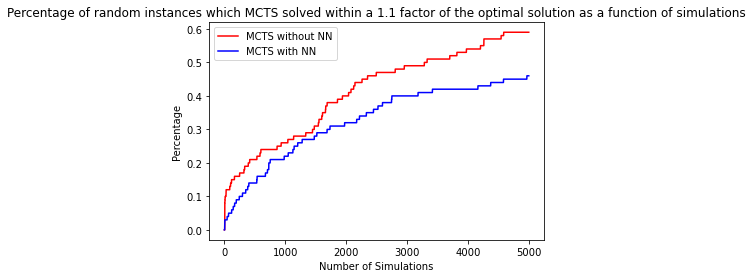

In [46]:
# plot graphs
import matplotlib.pyplot as plt

plt.plot(np.array(range(4999)), within_factor, "r")
plt.plot(np.array(range(4999)), within_factor_nn, "b")
plt.title("Percentage of random instances which MCTS solved within a 1.1 factor of the optimal solution as a function of simulations")
plt.xlabel("Number of Simulations")
plt.ylabel("Percentage")
plt.legend(["MCTS without NN", "MCTS with NN"])

- From the graph above, we can see that MCTS without NN performed better than MCTS with NN.
- Due to time limitation, we couldn't improve model's performance, but we believe that a different architecture and training dataset might have provided better results.